# Clustering and Graph-based Analysis on gene expression dataset

We import all the necessary packages into the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle
from scipy.sparse import linalg

## Clustering

We first load the *gene_expression_data.csv* into pandas data frames, then convert them into numpy arrays.

In [201]:
gene_expression = pd.read_csv("gene_expression_data.csv")
gene_expression = gene_expression.to_numpy()

We now split the gene expression data set into descriptor set `gene` and type of tumour `gene_type`.

In [202]:
gene = gene_expression[:, :-1]
gene_type = gene_expression[:,-1]

The `k_means` function implements the k-means clustering algorithm using these steps:
1. Randomly assign the "labels" such that a given group of data points belong to one cluster
2. Compute the centroids of these clusters
3. Iterate to relabel our data points to the closest centroid until convergence or maximum number of iterations reached

In [203]:
def k_means(X, k, max_iter):
    """
    Arguments:
        X: descriptor set
        k: number of clusters
        max_iter: maximum number of iterations
    Returns:
        centroids: centroids of each cluster
        labels: labels of each data point
    """
    n_samples, n_features = X.shape
    
    # randomly assigning labels
    labels = np.random.randint(low=0, high=k, size=n_samples - k)
    labels = np.append(labels, np.arange(0, k))
    np.random.shuffle(labels)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features] 
    
    new_labels = np.zeros(len(X))
    difference = 0
    
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm((X - c).astype(float), axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            break
        else:
            # labels changed
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0) 
    return centroids, labels

The `calinski_harabasz` function computes the Calinski-Harabasz index via:
$$\text{CH}_{k}=\frac{\text{BCSM}}{k-1} \cdot \frac{n-k}{\text{WCSM}}$$
where n is the total number of data points and k the number of clusters. The BCSM (between cluster scatter matrix) is based on the distance between clusters:
$$\text{BCSM} = \sum_{i=1}^{k}{n_{i} \cdot d(z_{i}, z_{\text{tot}})^{2}}$$
where $z_{i}$ is the center of the cluster $c_{i}$ and $n_{i}$ the number of points in $c_{i}$. The WCSM (within-cluster scatter matrix) is given by:
$$\text{WCSM} = \sum_{i=1}^{k}{\sum_{x\in c_{i}}{d(x,z_{i})^{2}}}$$
where x is a data point belonging to cluster $c_{i}$.

In [204]:
def calinksi_harabasz(x, k, centroids, labels):
    """
    Arguments:
        x: descriptor set
        k: number of clusters
        centroids: centroids of each cluster
        labels: labels of each data point
    Returns:
        ch: Calinski-Harabasz index
    """
    n, m = x.shape
    center_x = np.mean(x, axis=0)
    counts = dict.fromkeys(np.arange(0, k, 1), 0)
    for label in labels:
        counts[label] += 1
    counts = np.array(list(counts.values()))
    BCSM = np.sum(counts * np.sum((centroids - center_x) ** 2, axis=1))
    WCSM = np.zeros(k)
    for i in range(k):
        index = np.where(labels==i)[0]
        WCSM[i] = np.sum(np.sum((gene[index,:] - centroids[i, :]) ** 2, axis=1))
    WCSM = np.sum(WCSM)
    ch = BCSM / (k - 1) * (n - k) / WCSM
    return ch

The `train_k_means` function runs k-means for a given number of different initialisations and averaging the corresponding Calinski-Harabasz indices.

In [205]:
def train_k_means(x, k_list, initial):
    """
    Arguments:
        x: descriptor set
        k_list: list of k values
        initial: number of initialisations
    Returns:
        best_k: k value which gives the greatest Calinski-harabasz index
        best_ch_mean: greatest Calinski-harabasz index
        best_labels: labels obtained from optimal k value
        ch_mean_list: list of average Calinski-harabasz index for each k
    """
    best_k = 1
    best_ch_mean = float('-inf')
    best_labels = None
    ch_mean_list = []
    for k in k_list:
        ch_list = []
        for i in range(initial):
            centroids, labels = k_means(x, k, max_iter=100)
            ch = calinksi_harabasz(x, k, centroids, labels)
            ch_list.append(ch)
        ch_mean = np.mean(ch_list)
        ch_mean_list.append(ch_mean)
        if ch_mean > best_ch_mean:
            best_ch_mean = ch_mean
            best_k = k
            best_labels = labels
    return best_k, best_ch_mean, best_labels, ch_mean_list

We determine the optimal k by running k-means, for each k in the range 2 to 10, for 5 different initialisations.

In [210]:
k_list = np.arange(2, 11, 1)
best_k, best_ch_mean, best_labels, ch_mean_list = train_k_means(gene, k_list, 5)

We plot the average Calinski-Harabasz index as a function of k.

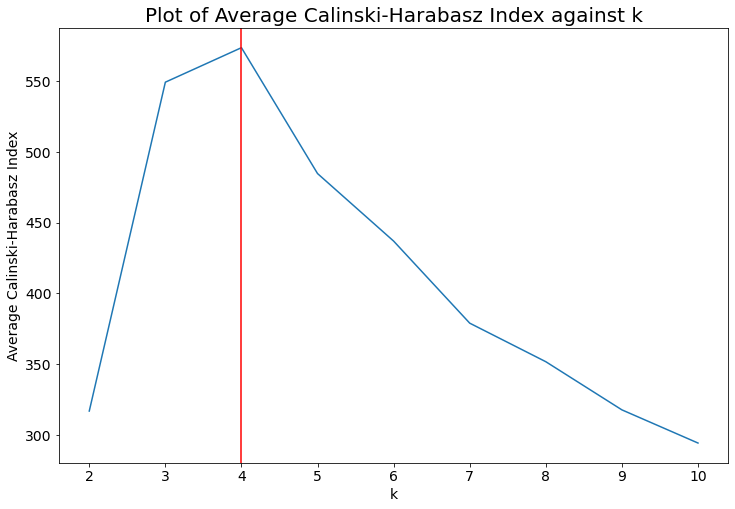

In [211]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(k_list, ch_mean_list)
plt.axvline(x=best_k, color="r")
plt.xlabel('k',fontsize=14)
plt.ylabel('Average Calinski-Harabasz Index',fontsize=14)
plt.title("Plot of Average Calinski-Harabasz Index against k", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

We can observe that the avergae Calinkski-Harabasz index achieves maximum when k=4.

In [212]:
print("The optimal value of k is {}".format(best_k))

The optimal value of k is 4


In [213]:
# Table of size of clusters found by k-means for optimal k
label_1, size_1 = np.unique(best_labels, return_counts=True)
data_k1 = {'': [label_1[0], size_1[0]], ' ': [label_1[1], size_1[1]], '  ':[label_1[2], size_1[2]], '   ':[label_1[3], size_1[3]]}
df_k1 = pd.DataFrame(data_k1, index=['Cluster', 'Size'])
df_k1 = df_k1.style.set_properties(**{'font-size': '14pt'})
df_k1 = df_k1.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_k1

,,,,
Cluster,0,1,2,3
Size,143,122,400,135


The `homogeneity_score` function computes the homogeneity socre via: <br>
Given a set of classes $C$ and a set of clusters $K$ of size, respectively $|C|$ and $|K|$,
$$\text{Homeogeneity score} = 1 - \frac{H(C|K)}{H(C)}$$
where the symbols H denote entropies defined as follow:
$$H(C|K) = -\sum_{k=1}^{|K|}{\sum_{c=1}^{|C|}{\frac{a_{ck}}{N}\log\frac{a_{ck}}{\sum_{c=1}^{|C|}{a_{ck}}}}} \quad \quad H(C) = -\sum_{c=1}^{|C|}{\frac{\sum_{k=1}^{|K|}{a_{ck}}}{N}\log\frac{\sum_{k=1}^{|K|}{a_{ck}}}{N}}$$
N is the total number of data points and $a_{ck}$ is the number of data points that belong to class c and are assigned to class k.

In [214]:
def homogeneity_score(x, true_labels, cluster_labels):
    """
    Arguments:
        x: descriptor set
        true_labels: true class labels
        cluster_labels: labels assigend by k means
    Returns:
        homogeneity score
    """
    N, M = x.shape
    c = np.unique(true_labels)
    k = np.unique(cluster_labels)
    a = np.zeros((len(c), len(k)))
    for i, true_label in enumerate(c):
        index_true = np.where(true_labels==true_label)[0]
        for j, cluster_label in enumerate(k):
            index_cluster = np.where(cluster_labels==cluster_label)[0]
            a[i, j] = len(np.intersect1d(index_true, index_cluster))
    h_c_k = -np.sum(np.sum(a / N * np.log(a / np.sum(a, axis=0), where=a>0), axis=0))
    h_c = -np.sum(np.sum(a, axis=1) / N * np.log(np.sum(a, axis=1) / N))
    return 1 - h_c_k / h_c

We compute the homogeneity score to assess the consistency between the clustering of the samples obtained in **2.1.1** and the assignment to these classes (tumour types).

In [215]:
print("Homogeneity score = {}".format(homogeneity_score(gene, gene_type, best_labels)))

Homogeneity score = 0.6653242487126452


The homogeneity score of approximately 0.67 suggests that the clusters obtained from k-means is moderately consistent with the sample tumour types. The homogeneity score measures the extent to which the data points in one cluster belong to the same class. As the optimal number of clusters obtained from k-means is 4 and the true number of tumour types is 5, there is high possibility for data points not belonging in the same class to be categorised into the same cluster. This results in the not so high homogeneity score. Thus, a homogeneity score of approximately 0.67 indicates that the clusters are reasonably homogenous, but there is still room for improvement.

## Graph-based analysis

We compute the matrix of connected correlations between the genes and use it as a similarity matrix to construct a graph that links the genes. This matrix will be the adjacency matrix $A$ of a weighted graph describing gene co-expression.

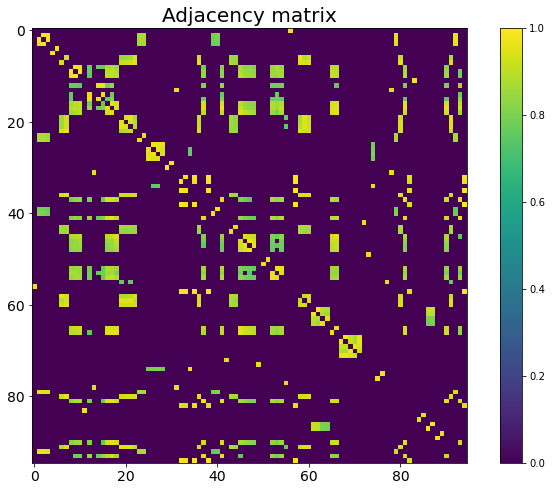

In [216]:
# compute correlation matrix
corr = np.corrcoef(gene.astype(float), rowvar=False)
# set the diagonal terms to zero
np.fill_diagonal(corr, 0)
# set all the terms whose absolute value is smaller than 0.75 to 0
A = np.where(np.abs(corr) < 0.75, 0, corr)

# visualise A
fig, ax = plt.subplots(figsize=(12,8))
plt.imshow(A)
plt.colorbar()
plt.title("Adjacency matrix", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

We compute the degree centrality of each node in the network using the formula:
$$c_{d} = \frac{d}{2E} = \frac{A1}{2E}$$
where $d$ is the degree vector and $E = \frac{1}{2}\sum_{i=1}^{N}{dd^{T}}$.

In [246]:
d = A @ np.ones(len(gene.T))
E = np.sum(d) / 2
c = d / (2 * E)
gene_index = np.argsort(c)[::-1][:5]
gene_c = c[gene_index]

In [252]:
# Table of degree centrality for top 5 ranking genes in full graph
data_c1 = {'': [gene_index[0], gene_c[0]], ' ': [gene_index[1], gene_c[1]], '  ':[gene_index[2], gene_c[2]], '   ':[gene_index[3], gene_c[3]], '    ':[gene_index[4], gene_c[4]]}
df_c1 = pd.DataFrame(data_c1, index=['Gene Index', 'Degree Centrality'])
df_c1.iloc[0] = df_c1.iloc[0].apply(lambda x: "{:.0f}".format(x))
df_c1 = df_c1.style.set_properties(**{'font-size': '14pt'})
df_c1 = df_c1.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_c1

,,,,,
Gene Index,17,41,16,81,90
Degree Centrality,0.026873,0.025935,0.025378,0.025231,0.024870


We compute the symmetric normalised Laplacian of the graph via:
$$\boldsymbol L = \boldsymbol I - \boldsymbol D^{-1/2}\boldsymbol A \boldsymbol D^{-1/2}$$
where $\boldsymbol D$ is our diagonal matrix of node degrees and $\boldsymbol A$ is our adjacency matrix.

In [253]:
# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(d)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

We derive the eigenvectors and eigenvalues of the symmetric normalised Laplacian of the graph.

In [254]:
eigenvals, eigenvecs = linalg.eigsh(L_norm, 95, which="SM", return_eigenvectors=True)

We obtain the index of the eigenvevalues that have zero values upon numerical rounding.

In [255]:
index_0 = np.where(np.round(eigenvals, decimals=6)==0)[0]

We plot the spectrum of eigenvalues and mark the gap between eigenvalues that, upon numerical rounding, have respectively zero and non-zero values.

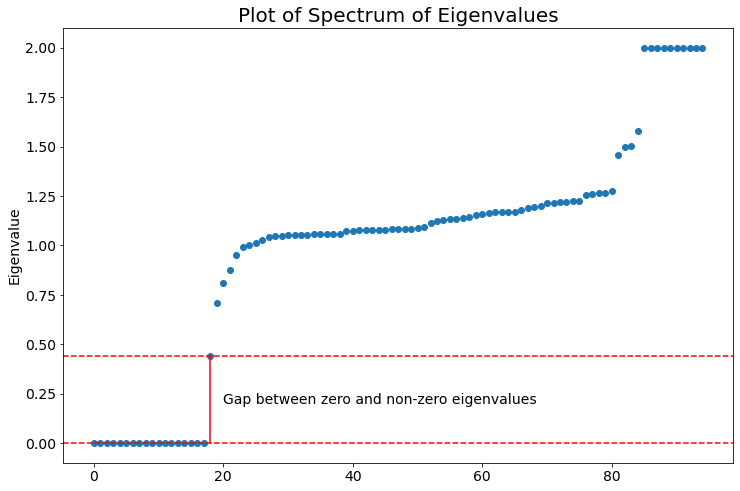

In [270]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(eigenvals, 'o')
plt.axhline(y = 0, color='r', linestyle='--')
plt.axhline(y = eigenvals[index_0[-1]+1], color='r', linestyle='--')
plt.plot([index_0[-1]+1, index_0[-1]+1], [0, eigenvals[index_0[-1]+1]], linestyle='-', color='r')
plt.text(20, 0.2, "Gap between zero and non-zero eigenvalues", fontsize=14)
plt.ylabel('Eigenvalue',fontsize=14)
plt.title("Plot of Spectrum of Eigenvalues", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [271]:
r = len(index_0)
print("The number of zero eigenvalues is {}".format(r))

The number of zero eigenvalues is 18


The number of zero eigenvalues indicates the number of disconnected components in the graph network. There are no edges that connect nodes from one disconnected component to nodes in another disconnected component. This tells us that there are 18 disconnected components in this graph network.

We let U be the 95 x 18 matrix containing the 18 eigenvectors of the symmetric normalised Laplacian corresponding to zero eigenvalues as columns. We then form T of size 95 x 18 by normalising U via:
$$T_{ij}=\frac{U_{ij}}{\sqrt{\sum_{k}{U_{ik}^{2}}}}$$

In [272]:
U = eigenvecs[:, :r]
T = U / np.sqrt(np.sum(U**2, axis=1)).reshape(-1, 1)

The `within_cluster_dist` function computes the normalised within-cluster distance for a given clustering $C=\{c_{l}\}_{l=1}^{k}$ via:
$$W(C) = \frac{1}{2}\sum_{l=1}^{k}{\frac{1}{|c_{l}|}\sum_{i,j\in c_{l}}{\lVert x^{(i)} - x^{(j)} \rVert^{2}}}$$
where $|c_{l}|$ is the cardinality of $c_{l}$.

In [274]:
def within_cluster_dist(x, labels):
    """
    Arguments:
        x: descriptor set
        k: number of clusters
        labels: labels of each data point
    Returns:
        w: normalised within-cluster distance
    """
    c_array = np.array([])
    dist_array = np.array([])
    for label in np.unique(labels):
        index = np.where(labels==label)[0]
        c = len(index)
        inter_dist = np.sum(pdist(x[index, :], 'euclidean')**2)
        c_array = np.append(c_array, c)
        dist_array = np.append(dist_array, inter_dist)
    w = np.sum(dist_array / c_array)
    return w

The `train_k_means_graph` function runs k-means for a given number of different initialisations and returns the minimum normalised within-cluster distance for each k from a list of k values.

In [275]:
def train_k_means_graph(x, k_list, initial):
    """
    Arguments:
        x: descriptor set
        k_list: list of k values
        initial: number of initialisations
    Returns:
        labels_list: list containing lists of labels for each k
        w_min_list: list of minimum normalised within-cluster distance for each k
    """
    labels_list = []
    w_min_list = []
    for k in k_list:
        w_list = []
        for i in range(initial):
            centroids, labels = k_means(x, k, max_iter=500)
            w = within_cluster_dist(x, labels)
            w_list.append(w)
        w_min = np.min(w_list)
        w_min_list.append(w_min)
        labels_list.append(labels)
    return labels_list, w_min_list

To find the appropriate value of k, we use the elbow method by trying a range of increasing k's until there is no longer any significant improvement in the clustering.

In [356]:
k_list = np.arange(2, 41, 1)
labels_list, w_min_list = train_k_means_graph(T, k_list, 100)

We set a tolerance of $10^{-10}$ for the difference between the minimum normalised within-cluster distance for the current k and previous k.

In [357]:
k_best = np.where(np.array([np.abs(a - b) for a, b in zip(w_min_list, w_min_list[1:] + [0])])<1e-10)[0][0] + 1

To visualise the elbow of the curve, we plot minimum normalised within-cluster distance against k.

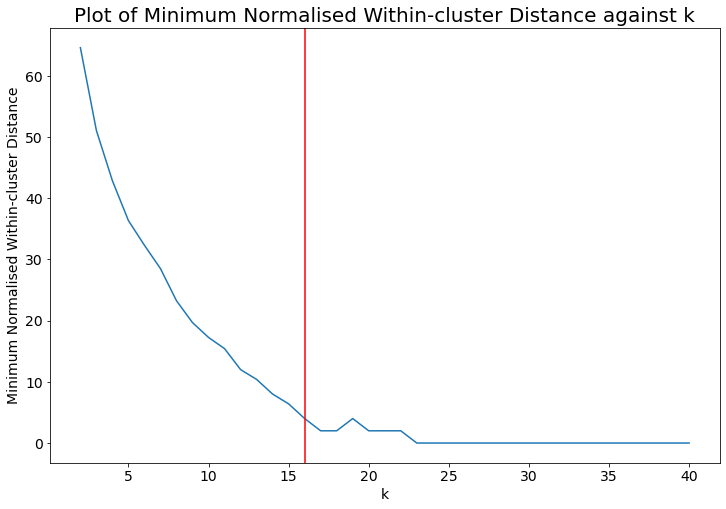

In [358]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(k_list, w_min_list)
plt.axvline(x=k_best, color='r')
plt.xlabel('k',fontsize=14)
plt.ylabel('Minimum Normalised Within-cluster Distance',fontsize=14)
plt.title("Plot of Minimum Normalised Within-cluster Distance against k", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [359]:
print("The optimal value of k is {}".format(k_best))

The optimal value of k is 16


In [360]:
# Table of size of clusters found by k-means for optimal k
labels_best, counts_best = np.unique(labels_list[k_best - 2], return_counts=True)
data_k2 = {'Cluster': labels_best, 'Size': counts_best}
df_k2 = pd.DataFrame(data_k2).T
df_k2.set_index(pd.Index(['Cluster', 'Size']))
df_k2 = df_k2.style.set_properties(**{'font-size': '14pt'})
df_k2 = df_k2.set_table_styles([{'selector': 'thead', 'props': [('display', 'none')]}, {'selector': 'th', 'props': [('font-size', '14pt')]}])
df_k2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Size,9,2,4,7,2,23,2,2,7,16,3,6,6,2,2,2


We now reorder the adjacency matrix by the clusters assigned.

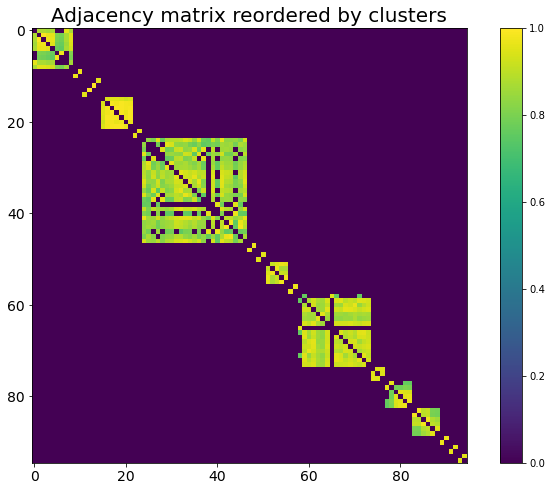

In [361]:
arranged = np.argsort(labels_list[k_best - 2])

fig, ax = plt.subplots(figsize=(12,8))
plt.imshow(A[arranged, :][:, arranged])
plt.colorbar()
plt.title("Adjacency matrix reordered by clusters", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

The resulting clusters identify groups of genes with similar expression patterns across the different tumour sample types. The genes within the same cluster are tightly connected to each other but weakly connected to genes in other clusters. This indicates that the genes within the same cluster are involved in similar biological mechanisms related to tumour growth.

We now consider the biggest cluster identified above, which is the cluster with 23 nodes.

In [362]:
biggest_cluster = [np.argmax(counts_best)]
biggest_cluster_index = np.where(labels_list[k_best - 2]==biggest_cluster)[0]
A_c = A[biggest_cluster_index,:][:,biggest_cluster_index]

We use the normalised Laplacian to perform spectral partitioning and derive a binary partition of the subgraph corresponding to this cluster.

In [363]:
weighted_degree_c = A_c.sum(axis=1) 

# computing inverse square root vector of degree
weighted_degree_sqrt_c = 1.0 / np.sqrt(weighted_degree_c)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt_c = np.diag(weighted_degree_sqrt_c)

# define the normalised Laplacian
L_norm_c = np.eye(A_c.shape[0]) - D_inv_sqrt_c.dot(A_c.dot(D_inv_sqrt_c))

In [364]:
eigenvals_c, eigenvecs_c = linalg.eigsh(L_norm_c, 2, which="SM", return_eigenvectors=True)

We assign all elements in the second eigenvector with negative values to the one partition and all elements in the second eigenvector with positive values to the other partition.

In [365]:
second_eigenvector = eigenvecs_c[:,1]
partition_0 = second_eigenvector[second_eigenvector > 0]
partition_1 = second_eigenvector[second_eigenvector < 0]

We visualise the magnitude of the network links within each partition and across the two partitions.

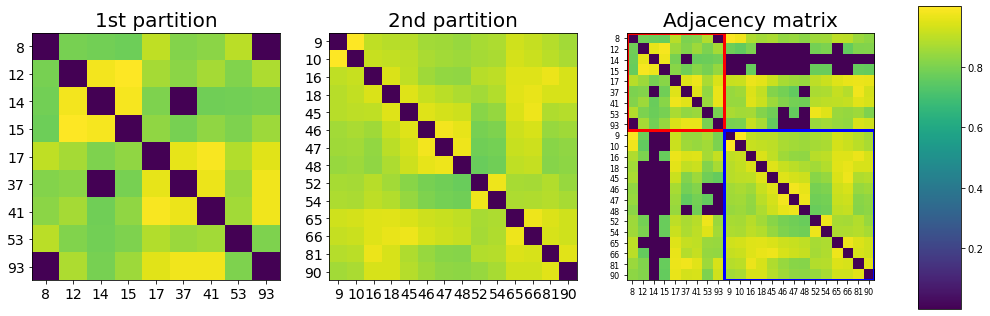

In [366]:
partition_0_index = np.where(second_eigenvector>0)[0]
partition_1_index = np.where(second_eigenvector<0)[0]

fig, ax = plt.subplots(figsize=(12,6))
plt.subplot(1, 3, 1)
plt.imshow(A_c[partition_0_index, :][:, partition_0_index])
plt.title("1st partition", fontsize=20)
plt.xticks(range(len(partition_0_index)), biggest_cluster_index[partition_0_index], size=14)
plt.yticks(range(len(partition_0_index)), biggest_cluster_index[partition_0_index], size=14)

plt.subplot(1, 3, 2)
plt.imshow(A_c[partition_1_index, :][:, partition_1_index])
plt.title("2nd partition", fontsize=20)
plt.xticks(range(len(partition_1_index)), biggest_cluster_index[partition_1_index], size=14)
plt.yticks(range(len(partition_1_index)), biggest_cluster_index[partition_1_index], size=14)

rearranged_partition_index = np.concatenate((partition_0_index, partition_1_index))
plt.subplot(1, 3, 3)
plt.imshow(A_c[rearranged_partition_index, :][:, rearranged_partition_index])
plt.gca().add_patch(Rectangle((-0.5, -0.5), len(partition_0), len(partition_0), fill=False, linewidth=3, color="red"))
plt.gca().add_patch(Rectangle((len(partition_0)-0.5, len(partition_0)-0.5), len(partition_1), len(partition_1), fill=False, linewidth=3, color="blue"))
plt.title("Adjacency matrix", fontsize=20)
plt.xticks(range(len(rearranged_partition_index)), biggest_cluster_index[rearranged_partition_index], size=8)
plt.yticks(range(len(rearranged_partition_index)), biggest_cluster_index[rearranged_partition_index], size=8)

fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.15, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax=cbar_ax)

plt.show()

We can observe that the weights between each of the genes within the same partition have high magnitude, suggesting that the genes in the same partition are strongly related. Comparing the strength of the within partition network links of the two partitons, we can notice that all the genes in the 2nd partiton are linked to each other with high magnitude network links, whereas there are a few nodes in the 1st partition that are not linked, which suggests that the relationship between the genes in the 2nd partition is stronger than the 1st partition. <br>

We can also observe that gene with index 14 in the 1st partition is not linked to any other gene in the 2nd partition. There are also a few genes that do not link to genes in the other partition. This implies that the relationship between genes across different partitions is weaker than the relationship between genes within the same partitions.

We compute the degree centrality of the nodes in the subgraph using the same formula as above.

In [370]:
d_c = A_c @ np.ones(len(A_c))
E_c = np.sum(d_c) / 2
c_c = d_c / (2 * E_c)
gene_c_index = np.argsort(c_c)[::-1][:5]
gene_index2 = biggest_cluster_index[gene_c_index]
gene_c2 = c_c[gene_c_index]

In [373]:
# Table of degree centrality for top 5 ranking genes in subgraph
data_c2 = {'': [gene_index2[0], gene_c2[0], gene_c[0]], ' ': [gene_index2[1], gene_c2[1], gene_c[1]], '  ':[gene_index2[2], gene_c2[2], gene_c[2]], '   ':[gene_index2[3], gene_c2[3], gene_c[3]], '    ':[gene_index2[4], gene_c2[4], gene_c[4]]}
df_c2 = pd.DataFrame(data_c2, index=['Gene Index', 'Degree Centrality (Subgraph)', 'Degree Centrality (Full graph)'])
df_c2.iloc[0] = df_c2.iloc[0].apply(lambda x: "{:.0f}".format(x))
df_c2 = df_c2.style.set_properties(**{'font-size': '14pt'})
df_c2 = df_c2.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_c2

,,,,,
Gene Index,17,41,16,81,90
Degree Centrality (Subgraph),0.052890,0.051044,0.049948,0.049657,0.048948
Degree Centrality (Full graph),0.026873,0.025935,0.025378,0.025231,0.024870


We can observe that the 5 top-ranking genes with the highest degree centralities for the subgraph are the same as the 5 top-ranking genes for the full graph. This suggests that these genes are highly connected within the largest cluster subgraph and also have a high degree of connectivity with genes outside of the cluster. Thus, we may infer that these genes play a central role in biological mechanisms related to tumour growth both within and outside of the largest cluster. <br>

We notice that the degree centrality for each gene in the subgraph has approximately doubled in comparison to the degree centrality in the full graph. This suggests that the genes within the largest cluster are highly interconnected and exhibit stronger relationship with the genes within the cluster than the genes outside of the cluster. This could indicate that the biological mechanism related to tumour growth involving genes within the largest cluster might be different from the biological mechanisms related to tumour growth involving genes outside of the cluster.